### Creating a LSTM Model

In [1]:
from pymongo import MongoClient
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd
import pickle
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas()

In [2]:
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import LSTM , Dense , Flatten , Dropout , Input
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping

In [3]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix , accuracy_score

In [4]:
from Create_dataset import actions

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\python.exe
2.18.0
0.10.18


In [5]:
# File Path to store the landmark data

DATA_PATH = os.path.join("LANDMARK_DATA")

# Defining the actions 
actions = np.array(['hello' , 'thankyou' , 'My' , 'sorry', 'Name' , 'You' , 'I am' , 'Nice' ,'Meet' , 'Fine', 'I'])
# Defining the number of videos per action

no_of_videos = 100

# Defining the number of frames per video

no_of_frames = 30

In [6]:

# Creating Label Map 

label_map = {label:num for num , label in enumerate(actions)}

In [7]:
label_map

{'hello': 0,
 'thankyou': 1,
 'My': 2,
 'sorry': 3,
 'Name': 4,
 'You': 5,
 'I am': 6,
 'Nice': 7,
 'Meet': 8,
 'Fine': 9,
 'I': 10}

In [8]:
tf.random.set_seed(17)
np.random.seed(17)
random.seed(17)

#### 1. Extracting Data from MongoDB

In [9]:
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Preprocessed_Landmark_Data']

In [10]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

In [11]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda landmarks : [np.array(x) if isinstance(x , list) else x for x in landmarks])

100%|██████████| 1100/1100 [00:07<00:00, 143.66it/s]


In [12]:
df['Landmarks'][0]

[array([ 0.48907107,  0.31065953, -1.52472782, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.50588286,  0.43122151, -1.3196938 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51067424,  0.43701315, -1.17469358, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52083284,  0.44172639, -1.05210757, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51937109,  0.44772437, -1.02967119, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51915282,  0.45715916, -0.74745756, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51843125,  0.46929976, -0.87260878, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51749331,  0.46095556, -0.70599127, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51346844,  0.45430243, -0.86979645, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51234734,  0.45008966, -0.7774955 , ...,  0.2658312 ,
         0.63843787, -0.03

In [13]:
X = np.array(df['Landmarks'].tolist())
labels_list = (df['Labels'].tolist())
y = to_categorical(labels_list).astype(int)


In [14]:
X.shape

(1100, 30, 1662)

In [15]:
y.shape

(1100, 11)

In [16]:
X

array([[[ 0.48907107,  0.31065953, -1.52472782, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.50588286,  0.43122151, -1.3196938 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.51067424,  0.43701315, -1.17469358, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.4926661 ,  0.43284616, -0.76935244, ...,  0.16717376,
          0.15810913, -0.05844192],
        [ 0.49296832,  0.43348545, -0.77340305, ...,  0.16804329,
          0.16028863, -0.05659148],
        [ 0.49369201,  0.43327758, -0.77868259, ...,  0.1671429 ,
          0.16293401, -0.05479354]],

       [[ 0.49377102,  0.43369636, -0.78066176, ...,  0.16670072,
          0.16406117, -0.05632574],
        [ 0.47779107,  0.43192369, -0.75557107, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.47237068,  0.43091211, -0.74847233, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.46164799,  0.45209727, -0.84796935, ...,  

#### 2. Performing Train-test split
- using 95-5  percent train-test split

In [17]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.05)

In [18]:
print("X-train shape:" , X_train.shape)
print("X-test shape:" , X_test.shape)
print("y-train shape:" , y_train.shape)
print("y-test shape:" , y_test.shape)

X-train shape: (1045, 30, 1662)
X-test shape: (55, 30, 1662)
y-train shape: (1045, 11)
y-test shape: (55, 11)


Creating LSTM Model Architecture

In [19]:
# Creating a Instance of Early Stopping

early_stopping_callback = EarlyStopping(
 monitor = 'val_loss',
 patience = 5,
 mode = 'min',
 restore_best_weights = True
)

In [20]:
X_train.shape

(1045, 30, 1662)

In [21]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [22]:
# Constructing LSTM Model

LSTM_model = Sequential()
LSTM_model.add(LSTM(64, return_sequences= True , activation = 'relu' , input_shape = (30 , 1662)))
LSTM_model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
# model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
LSTM_model.add(LSTM(64 , return_sequences= False , activation='relu'))
# model.add(Dense(128 , activation ='relu'))
# model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(32 , activation = 'relu'))
LSTM_model.add(Dense(actions.shape[0] , activation='softmax'))

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,939 (2.28 MB)

 Trainable params: 596,939 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compiling the Model 

LSTM_model.compile(optimizer='Adam' , loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [25]:
LSTM_model_history = LSTM_model.fit(X_train , y_train , epochs = 300 , validation_split= 0.2)

Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - categorical_accuracy: 0.0906 - loss: 2.9642 - val_categorical_accuracy: 0.0957 - val_loss: 2.4099
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.1108 - loss: 2.3900 - val_categorical_accuracy: 0.1148 - val_loss: 2.7482
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.0861 - loss: 2.4537 - val_categorical_accuracy: 0.0957 - val_loss: 2.4514
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.1095 - loss: 2.4105 - val_categorical_accuracy: 0.0718 - val_loss: 2.3687
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.1357 - loss: 2.5624 - val_categorical_accuracy: 0.0813 - val_loss: 2.3851
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.1212 - loss: 2.4061 - val_categorical_accuracy: 0.0670 - val_loss: 2.3823
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.1206 - los

Visualizing the outcomes

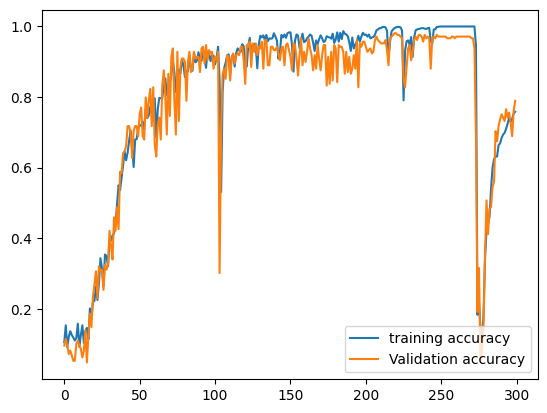

In [26]:
plt.plot(LSTM_model_history.history['categorical_accuracy'] , label = 'training accuracy')
plt.plot(LSTM_model_history.history['val_categorical_accuracy'] , label = 'Validation accuracy')
plt.legend(loc ='lower right')

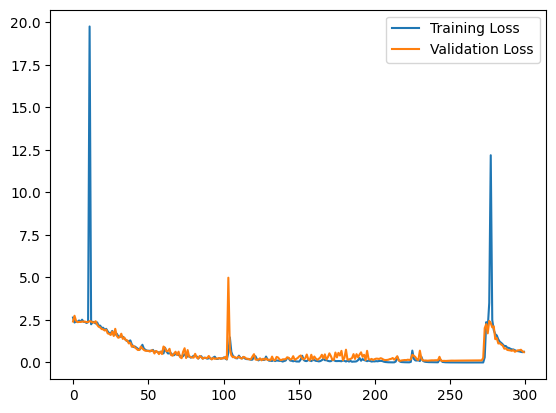

In [27]:
plt.plot(LSTM_model_history.history['loss'] , label = 'Training Loss')
plt.plot(LSTM_model_history.history['val_loss'] , label = 'Validation Loss')
plt.legend(loc = 'upper right')

In [28]:
LSTM_model.evaluate(X_test , y_test , verbose = 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.6898 - loss: 0.7380


[0.7438979148864746, 0.6909090876579285]

#### 3. Predicting Results

In [29]:
predictions = LSTM_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step


In [30]:
predictions[0]

array([1.6710780e-03, 1.6401605e-04, 2.7900510e-03, 5.5031735e-05,
       1.2685429e-07, 2.1369013e-01, 9.1313496e-02, 1.8008593e-07,
       1.8197130e-06, 4.7738286e-04, 6.8983668e-01], dtype=float32)

In [31]:
actions[np.argmax(predictions[0])]

'I'

In [32]:
actions[np.argmax(y_test[0])]

'I'

In [33]:
results , actual = [] , []

for result in predictions:
  
  outcome = actions[np.argmax(result)]

  results.append(outcome)
  

for i in range(len(y_test)):

  act_out = actions[np.argmax(y_test[i])] 

  actual.append(act_out)


In [34]:
results

['I',
 'I am',
 'I am',
 'hello',
 'I am',
 'hello',
 'I am',
 'Name',
 'I',
 'Name',
 'Nice',
 'thankyou',
 'Name',
 'I',
 'Meet',
 'Fine',
 'I',
 'hello',
 'sorry',
 'hello',
 'Fine',
 'I',
 'hello',
 'Fine',
 'sorry',
 'I am',
 'Name',
 'I am',
 'I',
 'I',
 'Meet',
 'I',
 'I am',
 'Name',
 'sorry',
 'Name',
 'thankyou',
 'sorry',
 'Fine',
 'I am',
 'I',
 'Name',
 'I am',
 'I am',
 'Name',
 'I',
 'thankyou',
 'Meet',
 'I am',
 'I',
 'I am',
 'sorry',
 'Nice',
 'Nice',
 'I am']

In [35]:
actual

['I',
 'sorry',
 'My',
 'hello',
 'My',
 'hello',
 'My',
 'Nice',
 'You',
 'Name',
 'Nice',
 'thankyou',
 'Name',
 'I',
 'Meet',
 'Fine',
 'I',
 'hello',
 'sorry',
 'hello',
 'Fine',
 'I',
 'hello',
 'I am',
 'Meet',
 'I am',
 'Meet',
 'sorry',
 'I',
 'I',
 'Meet',
 'I',
 'I am',
 'Name',
 'Name',
 'Name',
 'thankyou',
 'Meet',
 'Fine',
 'I am',
 'You',
 'Nice',
 'My',
 'Fine',
 'Name',
 'I',
 'thankyou',
 'Meet',
 'I am',
 'I',
 'I am',
 'sorry',
 'Nice',
 'Nice',
 'sorry']

In [36]:
type(results)

list

In [37]:
comparision_df = pd.DataFrame({'y_true' : actual , 'y_pred': results})

In [38]:
comparision_df

,y_true,y_pred
0,I,I
1,sorry,I am
2,My,I am
3,hello,hello
4,My,I am
5,hello,hello
6,My,I am
7,Nice,Name
8,You,I
9,Name,Name


#### 4. Saving the model Weights

In [39]:
with open('LSTM_model' , 'wb') as file:
  pickle.dump(LSTM_model , file)

#### 5.Evaluation using Confusion Matrix and accuracy

In [40]:
y_hat = LSTM_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [41]:
y_hat

array([[1.67107803e-03, 1.64016048e-04, 2.79005105e-03, 5.50317345e-05,
        1.26854289e-07, 2.13690132e-01, 9.13134962e-02, 1.80085934e-07,
        1.81971302e-06, 4.77382855e-04, 6.89836681e-01],
       [1.03536338e-04, 1.33017485e-03, 1.08927919e-03, 2.79845297e-01,
        4.44644189e-04, 3.32020409e-02, 3.55582237e-01, 7.85954355e-04,
        3.38021875e-03, 3.06699097e-01, 1.75374988e-02],
       [4.81032243e-04, 7.25572277e-03, 2.94268489e-01, 2.79876083e-04,
        2.79026182e-07, 9.40888673e-02, 5.54739535e-01, 2.51852180e-06,
        1.68319908e-04, 3.05361697e-03, 4.56617214e-02],
       [9.99998331e-01, 4.59751844e-19, 6.25144576e-13, 1.18615677e-36,
        1.09249230e-37, 1.70468047e-06, 3.03183758e-12, 6.17248264e-38,
        1.31279846e-24, 7.35177971e-33, 3.44715940e-16],
       [2.09698759e-04, 4.70455177e-03, 6.57400861e-02, 2.16321065e-03,
        5.64444508e-06, 1.23379655e-01, 5.53072572e-01, 2.20635811e-05,
        1.13319384e-03, 1.86840817e-01, 6.27284199e-

In [42]:
y_hat =  np.argmax(y_hat , axis = 1).tolist()
y_true = np.argmax(y_test , axis = 1).tolist()

In [43]:
print(y_true)
print(y_hat)

[10, 3, 2, 0, 2, 0, 2, 7, 5, 4, 7, 1, 4, 10, 8, 9, 10, 0, 3, 0, 9, 10, 0, 6, 8, 6, 8, 3, 10, 10, 8, 10, 6, 4, 4, 4, 1, 8, 9, 6, 5, 7, 2, 9, 4, 10, 1, 8, 6, 10, 6, 3, 7, 7, 3]
[10, 6, 6, 0, 6, 0, 6, 4, 10, 4, 7, 1, 4, 10, 8, 9, 10, 0, 3, 0, 9, 10, 0, 9, 3, 6, 4, 6, 10, 10, 8, 10, 6, 4, 3, 4, 1, 3, 9, 6, 10, 4, 6, 6, 4, 10, 1, 8, 6, 10, 6, 3, 7, 7, 6]


In [44]:
multilabel_confusion_matrix(y_true , y_hat)

# This confusion matrix shows TP and TN for each and every class

array([[[50,  0],
        [ 0,  5]],

       [[52,  0],
        [ 0,  3]],

       [[51,  0],
        [ 4,  0]],

       [[47,  3],
        [ 3,  2]],

       [[46,  3],
        [ 1,  5]],

       [[53,  0],
        [ 2,  0]],

       [[41,  8],
        [ 1,  5]],

       [[50,  0],
        [ 2,  3]],

       [[49,  0],
        [ 3,  3]],

       [[50,  1],
        [ 1,  3]],

       [[44,  2],
        [ 0,  9]]], dtype=int64)

In [45]:
accuracy_score(y_true , y_hat)

0.6909090909090909